**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn import preprocessing

**Creating the dataset**

In [ ]:
Age = [24,53,23,25,32,52,22,43,52,48]
Salary = [40000,52000,25000,77000,48000,110000,38000,44000,27000,65000]
CollegeDegree = ['Yes','No','No','Yes','Yes','Yes','Yes','No','No','Yes']

dataset = pd.DataFrame(np.array([Age,Salary,CollegeDegree]).T,columns=['Age','Salary','CollegeDegree'])

In [ ]:
dataset['Age'] =  dataset.Age.astype(int)
dataset['Salary'] = dataset.Salary.astype(int)

**Splitting the data into input and target features**

In [ ]:
X = np.array(dataset.drop('CollegeDegree',axis=1))
y = np.array(dataset['CollegeDegree'])

### **Univariate Decision Tree**

In [ ]:
class DecisionTreeClasifier(object):
  
    def __init__(self, features, max_depth):
        self.features = features
        self.max_depth = max_depth
        self.tree_depth = 0

    # entropy of a given segment of data
    def entropy(self, y): 
        cumulative_entropy = 0
        n_y = len(y)
        for label in set(y):   # iterating over each label in the segment
            n_label = sum(y==label)
            if n_label == 0 or n_y -n_label == 0:
              entropy = 0
            else:
              # calculating entropy of the label
              entropy = -(n_label *1.0/n_y)*math.log(n_label *1.0/n_y, 2) - ((n_y-n_label )*1.0/n_y)*math.log((n_y-n_label )*1.0/n_y, 2) 
              cumulative_entropy +=  n_label *1.0/n_y * entropy # weighted avg of entropies of each segment
        return cumulative_entropy # cumulative entropy of all the labels in the segment

    # entropy of the subtrees of a node
    def entropy_of_node(self, y_pred, y):
        if len(y_pred) == len(y): 
            n_y = len(y) 
            n_left = len(y[y_pred])
            entropy_left = self.entropy(y[y_pred]) # entropy of the left subtree
            n_right = n_y - n_left
            entropy_right = self.entropy(y[~y_pred]) # entropy of the right subtree
            # calculating total entropy of the node as a weighted average of the entropies of it's subtrees
            total_entropy = (n_left*1.0/n_y * entropy_left) + (n_right*1.0/n_y * entropy_right) 
            return total_entropy
        return None

    # calculating information gain
    def information_gain(self, col_ind, y):
        col_entropy = self.entropy(y) # entropy of the column
        min_entropy = 10
        for value in set(col_ind): # iterating over the unique values in the given column
            y_pred = col_ind < value # for any value in the column that is less than "value", y_pred is true. Else, it is false.
            pred_entropy = self.entropy_of_node(y_pred, y) # entropy of y_pred
            if pred_entropy <= min_entropy: # condition to check for least entropy, then calculate information gain for that
                threshold = value
                min_entropy = pred_entropy
                min_info_gain = col_entropy - pred_entropy
        return threshold, min_entropy, min_info_gain

    # finding the best splitting criterion at a given node
    def best_split(self, X, y):
        col_ind = None
        threshold = None
        min_entropy = 1
        min_info_gain = 10
        for i, c in enumerate(X.T): # iterating over the input features in X
            threshold_current, entropy, info_gain = self.information_gain(c, y)
            if entropy <= min_entropy: 
                col_ind = i
                threshold = threshold_current
                min_entropy = entropy
                min_info_gain = info_gain
            elif entropy == 0: # condition to find the best threshold, loop terminating condition
                col_ind = i
                threshold = threshold_current
                min_entropy = entropy
                min_info_gain = info_gain
                break
        return col_ind, threshold, min_entropy, min_info_gain

    def build_tree(self, X, y, depth): 
        col_ind, threshold, entropy, info_gain = self.best_split(X, y)  # calculating best split, returning the column, threshold, entropy, information gain for the best split 
        y_left, y_right = y[X[:, col_ind] < threshold], y[X[:, col_ind] >= threshold] # splitting the coumns based on the threshold of the best split
        node = {'Attribute': self.features[col_ind],
                'Threshold': threshold,
                'Information gain':info_gain} # node creation
        node['Left'] = self.fit(X[X[:, col_ind] < threshold], y_left, {}, depth+1) # constructing left subtree recursively
        node['Right'] = self.fit(X[X[:, col_ind] >= threshold], y_right, {}, depth+1) # constructing right subtree recursively
        self.tree_depth += 1 # incrementing the depth of the tree after adding one level 
        self.tree = node # updating the tree
        return node
    
    def fit(self, X, y, node={}, depth=0):
        if node is None or len(y) == 0 or depth >= self.max_depth: 
            return None
        elif len(pd.value_counts(y))==1: # counts number of unique values in y
            return {'val':y[0]}
        else: 
            return self.build_tree(X,y,depth)

**Building the decision tree for the given data**

In [ ]:
model = DecisionTreeClasifier(dataset.columns, max_depth=10)
dt = model.fit(X, y)
print("Tree:")
pprint(dt, sort_dicts= False)
print()
print("Depth of the tree: ", model.tree_depth)

Tree:
{'Attribute': 'Salary',
 'Threshold': 38000,
 'Information gain': 0.3219280948873623,
 'Left': {'val': 'No'},
 'Right': {'Attribute': 'Age',
           'Threshold': 43,
           'Information gain': 0.31127812445913283,
           'Left': {'val': 'Yes'},
           'Right': {'Attribute': 'Salary',
                     'Threshold': 65000,
                     'Information gain': 1.0,
                     'Left': {'val': 'No'},
                     'Right': {'val': 'Yes'}}}}

Depth of the tree:  3


### **Multivariate Decision Tree**

**Preprocessing the above data for Multivariate Decision tree**

In [ ]:
dataset['pred']=-1
label_encoder = preprocessing.LabelEncoder()
dataset['CollegeDegree']= label_encoder.fit_transform(dataset['CollegeDegree'])

In [ ]:
class MultiDecisionTreeClasifier(object):
    def __init__(self,feature_names,max_depth):
        self.feature_names = feature_names
        self.depth = 0
        self.max_depth = max_depth

   # entropy of a given segment of data
    def entropy(self,y):
        cumulative_entropy = 0
        n_y = len(y)
        for label in set(y):   # iterating over each label in the segment
            n_label = sum(y==label)
            if n_label == 0 or n_y -n_label == 0:
              entropy = 0
            else:
              # calculating entropy of the label
              entropy = -(n_label *1.0/n_y)*math.log(n_label *1.0/n_y, 2) - ((n_y-n_label )*1.0/n_y)*math.log((n_y-n_label )*1.0/n_y, 2) 
              cumulative_entropy +=  n_label *1.0/n_y * entropy # weighted avg of entropies of each segment
        return cumulative_entropy, n_y # cumulative entropy of all the labels in the segment, size of the segment
    
    # updating the alpha, beta values using the perceptron rule
    def perceptron(self, dataset, alpha, beta):
        for i in dataset.index:
            x_age = dataset["Age"][i]
            x_income = dataset["Salary"][i]
            # adjusting alpha, beta values at each split
            if alpha*x_age + beta*x_income - 1 >= 0:
                dataset['pred'][i]=1
                if(dataset['pred'][i] != dataset['CollegeDegree'][i]):
                    alpha = alpha-x_age
                    beta = beta-x_income
            else:
                dataset['pred'][i] = 0
                if(dataset['pred'][i] != dataset['CollegeDegree'][i]):
                    alpha = alpha + x_age
                    beta = beta + x_income
        return alpha, beta

    # calculating information gain 
    def information_gain(self, dataset, y, col_entropy, col_count):
        y_left = dataset['CollegeDegree'][dataset['pred']==0]
        n_left = len(y_left)
        entropy_left = self.entropy(y_left)[0] # entropy of left subtree
        y_right = dataset['CollegeDegree'][dataset['pred']==1]
        n_right = col_count - n_left 
        entropy_right= self.entropy(y_right)[0] # entropy of right subtree
        # calculating total entropy of the node as a weighted average of the entropies of it's subtrees
        total_entropy = (n_left/col_count)*entropy_left + (n_right/col_count)*entropy_right
        return (col_entropy- total_entropy), total_entropy # returning information gain and total entropy
    
    def fit(self, dataset, y):
        np.random.seed(70)
        # randomly initializing alpha and beta values
        alpha = np.random.rand()
        beta = np.random.rand()
        col_entropy = self.entropy(y)[0] # entropy of the column
        col_count = len(y)
        tmp = 0 # looping variable
        while tmp < 100:
          alpha, beta = self.perceptron(dataset, alpha, beta)

          info_gain, entropy = self.information_gain(dataset, y, col_entropy, col_count)

          self.alpha = alpha
          self.beta = beta
          self.info_gain = info_gain
          print("Information gain = {an:.4f} ".format(an = info_gain), "; Alpha = {an:.4f} ".format(an = alpha), " ; Beta = {an:.4f} ".format(an = beta), "; Entropy = {an:.4f} ".format(an = entropy))
          if(entropy == 0): # condition to find the best split, loop terminating condition
              break
          tmp += 1      

**Finding and printing alpha, beta and information gain at each split**

In [ ]:
multimodel = MultiDecisionTreeClasifier(dataset.columns, max_depth=10)
mtree = multimodel.fit(dataset, y)

Information gain = 0.0200  ; Alpha = -22.0725   ; Beta = 46000.8724  ; Entropy = 0.9510 
Information gain = 0.0074  ; Alpha = -145.0725   ; Beta = 0.8724  ; Entropy = 0.9635 
Information gain = 0.0200  ; Alpha = -168.0725   ; Beta = 46000.8724  ; Entropy = 0.9510 
Information gain = 0.0074  ; Alpha = -291.0725   ; Beta = 0.8724  ; Entropy = 0.9635 
Information gain = 0.0200  ; Alpha = -314.0725   ; Beta = 46000.8724  ; Entropy = 0.9510 
Information gain = 0.0074  ; Alpha = -437.0725   ; Beta = 0.8724  ; Entropy = 0.9635 
Information gain = 0.0200  ; Alpha = -460.0725   ; Beta = 46000.8724  ; Entropy = 0.9510 
Information gain = 0.0074  ; Alpha = -583.0725   ; Beta = 0.8724  ; Entropy = 0.9635 
Information gain = 0.0200  ; Alpha = -606.0725   ; Beta = 46000.8724  ; Entropy = 0.9510 
Information gain = 0.0074  ; Alpha = -729.0725   ; Beta = 0.8724  ; Entropy = 0.9635 
Information gain = 0.0200  ; Alpha = -752.0725   ; Beta = 46000.8724  ; Entropy = 0.9510 
Information gain = 0.0074  ; Al

**Plotting the results**

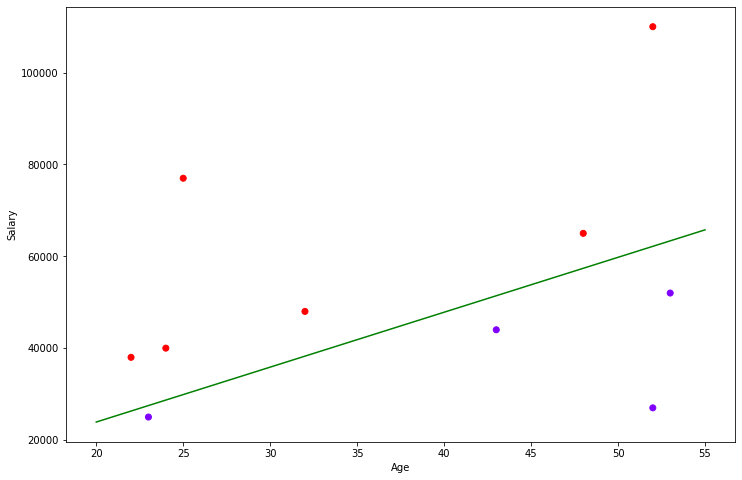

In [ ]:
fig2 = plt.figure()
fig2.set_size_inches(12,8)
ax2 = plt.axes()
ax2.scatter(data=dataset,x='Age',y='Salary',c='CollegeDegree',cmap=plt.cm.get_cmap("rainbow",3))
xx=np.linspace(20,55,2)
plt.xlabel("Age")
plt.ylabel("Salary")
ax2.plot(xx,(-1*(1/multimodel.beta) - (multimodel.alpha/multimodel.beta)*xx),color='green')
plt.show()

### **Advantages and Disadvantages of Multivariate Decision Trees compared to Univariate Decision Trees**

**Advantages:**

*   The univariate decision tree algorithm constructs the decision tree by selecting a single feature at each split, whereas the multivariate decision tree algorithm uses a linear combination of features. Unlike univariate decision trees, this produces a tree that better expresses the relationship between the features.
*   Multivariate decision trees converge much faster than univariate decision trees for linearly separable datasets.
*   Multivariate decision trees reduce the replication problems of univariate decision trees, increasing the accuracy of the resulting decision tree.

**Disadvantages:**
*   In multivariate decision trees, to take a linear combination of the features, we apply encoding techniques to convert nominal features into numeric values—the number of features obtained after the conversion increases, consequently increasing computational complexity.
*   When considering multiple features during a split, it is possible that the multivariate algorithm will select a feature that contributes no or little to the information gain.